In [1]:
!python -m pip install --upgrade tensorflow-probability
import tensorflow as tf
import numpy as np
from numpy import save
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle
from IPython.display import Image

import tensorflow_probability as tfp
import tensorflow_probability.python.distributions as tfd
import tensorflow_probability.python.layers as tfpl

#!python -m pip install git+https://github.com/mwaskom/seaborn.git
#import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})

import json
!python -m pip install batchup
from batchup import data_source
from collections import Counter
from sklearn.cluster import KMeans, SpectralClustering

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: tensorflow-probability in /home/ssbose/.local/lib/python3.7/site-packages (0.10.0)
Defaulting to user installation because normal site-packages is not writeable


## Step 1: Loading the datasets

In [2]:
X_train = np.load('/datasets/home/21/321/ee228sp20ta1/G51/train_set.npy')
X_valid = np.load('/datasets/home/21/321/ee228sp20ta1/G51/val_set.npy')

## Step 2: Scaling and reshaping the datasets

In [3]:
x_train = X_train[:,:,:216].copy()
x_train = x_train.reshape((X_train.shape[0]*X_train.shape[1],216))

x_valid = X_valid[:,:,:216].copy()
x_valid = x_valid.reshape((X_valid.shape[0]*X_valid.shape[1],216))

print(x_train.shape)
print(x_valid.shape)

scaler = MinMaxScaler().fit(x_train) 
scaled_train = scaler.transform(x_train)
scaled_valid = scaler.transform(x_valid)

s_train_reshaped = scaled_train.reshape(15001,96,216,1)
s_valid_reshaped = scaled_valid.reshape(2763,96,216,1)

(1440096, 216)
(265248, 216)


In [4]:
del X_train, X_valid, x_train, x_valid, scaled_train, scaled_valid

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((s_train_reshaped, s_train_reshaped))
valid_dataset = tf.data.Dataset.from_tensor_slices((s_valid_reshaped, s_valid_reshaped))

In [6]:
del s_train_reshaped

## Step 3: Shuffling and splitting the dataset into batches for training

In [7]:
BATCH_SIZE = 15
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)

## Step 4: Defining the number of latent dimensions and generating the prior distribution

In [42]:
encoded_size = 16 # dimensions of latent state
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),reinterpreted_batch_ndims=1)

## Step 5: Defining the architecture for the VAE

In [43]:
encoder = keras.Sequential([
    #layers.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    layers.Conv2D(96, 3, padding="same", activation = 'relu', input_shape = (96, 216, 1)),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(45, 3, activation="relu", padding="same"),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.4),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size)),
    tfpl.MultivariateNormalTriL(encoded_size, activity_regularizer = tfpl.KLDivergenceRegularizer(prior, weight = 1.0)),
])

In [9]:
## Run this cell if you need to review the encoder layer by layer
for layer in encoder.layers:
    print (layer)
    if (type(layer.output) is tuple):
        print (layer.output[0].shape, layer.output[1].shape)
    else:
        print (layer.output.shape)

(None, 96, 216, 96)
(None, 96, 216, 96)
(None, 96, 216, 96)
(None, 48, 108, 96)
(None, 48, 108, 45)
(None, 48, 108, 45)
(None, 48, 108, 45)
(None, 24, 54, 45)
(None, 24, 54, 16)
(None, 24, 54, 16)
(None, 24, 54, 16)
(None, 12, 27, 16)
(None, 5184)
(None, 152)
(None, 16) (None, 16)


In [44]:
decoder = keras.Sequential([
    layers.Input(shape = [encoded_size]),
    layers.Reshape((1, 1, encoded_size)),
    layers.Conv2DTranspose(16, 3, padding='valid'),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.5),
    layers.UpSampling2D(size=(2,3)),
    layers.Conv2DTranspose(45, 3, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.4),
    layers.UpSampling2D(size=(2,1)),
    layers.Conv2DTranspose(96, 3, activation='relu', padding='same'),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.2),
    layers.UpSampling2D(size=(2,1)),
    layers.Flatten(),
    #layers.Reshape((96, 216, 1)),
    #layers.Conv2DTranspose(1, 3, activation = 'sigmoid', padding = 'same'),
    tfpl.IndependentBernoulli((96, 216, 1), tfd.Bernoulli.logits)
])

In [11]:
## Run this cell if you wish to review the decoder layer by layer
for layer in decoder.layers:
    print (layer)
    if (type(layer.output) is tuple):
        print (layer.output[0].shape, layer.output[1].shape)
    else:
        print (layer.output.shape)

(None, 1, 1, 16)
(None, 3, 3, 16)
(None, 3, 3, 16)
(None, 3, 3, 16)
(None, 6, 9, 16)
(None, 6, 9, 45)
(None, 6, 9, 45)
(None, 6, 9, 45)
(None, 12, 9, 45)
(None, 12, 9, 96)
(None, 12, 9, 96)
(None, 12, 9, 96)
(None, 24, 9, 96)
(None, 20736)
(None, 96, 216, 1) (None, 96, 216, 1)


## Step 6: Compile the VAE

In [45]:
vae = keras.Model(inputs=encoder.inputs,outputs=decoder(encoder.outputs[0]))
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=negative_log_likelihood)

## Step 7: Training (and validating) the VAE

In [46]:
history = vae.fit(train_dataset, batch_size = 5, epochs = 125, validation_data = (valid_dataset), shuffle = True)

Epoch 1/125
1001/1001 [==============================] - 38s 38ms/step - loss: 14051.2402 - val_loss: 14119.0996
Epoch 2/125
1001/1001 [==============================] - 35s 35ms/step - loss: 14005.8906 - val_loss: 14102.7217
Epoch 3/125
1001/1001 [==============================] - 36s 36ms/step - loss: 14000.2363 - val_loss: 14101.6660
Epoch 4/125
1001/1001 [==============================] - 34s 34ms/step - loss: 13997.0498 - val_loss: 14093.6660
Epoch 5/125
1001/1001 [==============================] - 35s 35ms/step - loss: 13995.6611 - val_loss: 14132.9521
Epoch 6/125
1001/1001 [==============================] - 35s 35ms/step - loss: 13993.8643 - val_loss: 14106.9795
Epoch 7/125
1001/1001 [==============================] - 36s 36ms/step - loss: 13992.8135 - val_loss: 14094.4971
Epoch 8/125
1001/1001 [==============================] - 35s 35ms/step - loss: 13992.2764 - val_loss: 14102.7646
Epoch 9/125
1001/1001 [==============================] - 35s 35ms/step - loss: 13992.0684 - val_

Epoch 73/125
1001/1001 [==============================] - 34s 34ms/step - loss: 13988.6992 - val_loss: 14039.2500
Epoch 74/125
1001/1001 [==============================] - 35s 34ms/step - loss: 13988.6641 - val_loss: 14020.5879
Epoch 75/125
1001/1001 [==============================] - 35s 35ms/step - loss: 13988.6201 - val_loss: 14025.5781
Epoch 76/125
1001/1001 [==============================] - 34s 34ms/step - loss: 13988.5605 - val_loss: 14029.9082
Epoch 77/125
1001/1001 [==============================] - 34s 34ms/step - loss: 13988.4795 - val_loss: 14031.1328
Epoch 78/125
1001/1001 [==============================] - 35s 35ms/step - loss: 13988.4883 - val_loss: 14020.9248
Epoch 79/125
1001/1001 [==============================] - 34s 34ms/step - loss: 13988.3965 - val_loss: 14020.5342
Epoch 80/125
1001/1001 [==============================] - 33s 33ms/step - loss: 13988.4795 - val_loss: 14015.6377
Epoch 81/125
1001/1001 [==============================] - 34s 34ms/step - loss: 13988.42

## Step 8: Plotting the losses

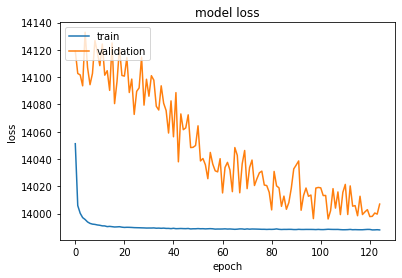

<Figure size 432x288 with 0 Axes>

In [47]:
#Plot train/validation loss vs epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.savefig('VAE05_epochs125.png')

## Step 9: Saving the (weights of the) model and the training history

In [64]:
import os
cwd = os.getcwd()
models_path = '/models-vae/model_05/'
vae.save_weights(cwd+models_path+'vae_05')

In [65]:
with open(cwd+models_path+'/VAE_05_trainHistoryDict.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Step 10: Visualize encoder-latent space-decoder

In [48]:
mini_batch = s_valid_reshaped[:100]
#print(mini_batch.shape)

decoded_data = vae.predict(valid_dataset)
#Obtain encoder representation of data
get_hl = K.function([vae.layers[0].input], [vae.layers[12].output])
AE_h1 = get_hl([mini_batch])[0]

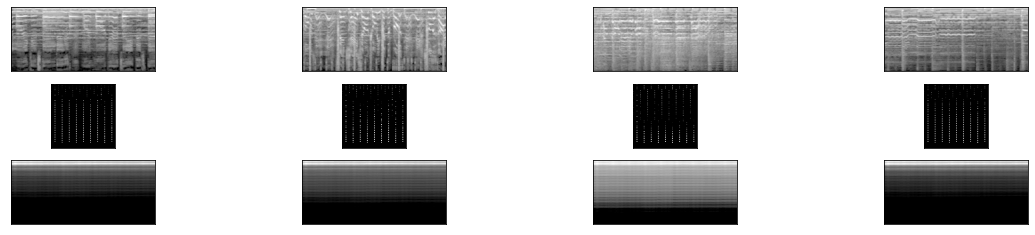

In [49]:
#Plot samples of input images, their hidden layer representations, and their reconstructions
n = 4  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(s_valid_reshaped[i].reshape(96, 216))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden layer representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(AE_h1[i].reshape(72, 72)) # Will have to reshape if you change the latent dimensionality
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_data[i].reshape(96, 216))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Community Detection based on Autoencoder results

### Step 1: Loading in Community Labels

In [50]:
with open('val_communities_3.json') as json_file:
    community_labels = json.load(json_file)

In [51]:
val_set = s_valid_reshaped

In [52]:
val_ids_path = '/datasets/home/21/321/ee228sp20ta1/G51/val_ids.txt'

### Step 2: Loading in IDs of songs in the validation set

In [53]:
f=open(val_ids_path, "r")
val_spec_ids = f.read()
val_spec_labels = val_spec_ids.split('\n')
# type(val_spec_labels)

### Step 3: Loading in the weights of the VAE

In [35]:
#models_path = '/datasets/home/21/321/ee228sp20ta1/G51/models-bose/'
vae.load_weights(models_path+'vae_04')

### Step 4: Create batches of validation spectrograms

In [54]:
ds = data_source.ArrayDataSource([val_set])

latent_vecs = []

get_hl = K.function([vae.layers[0].input], [vae.layers[12].output])

for batch in ds.batch_iterator(batch_size=64, shuffle=False):
    
    AE_h1 = get_hl([batch])[0]
    latent_vecs.append(AE_h1)
    
latent_vecs = np.array(latent_vecs)

latent_vecs = np.concatenate(latent_vecs)
#print(latent_vecs.shape)

In [55]:
latent_vectors = np.ndarray(shape=(2763,72,72))

for idx, spec in enumerate(val_set):
    latent_vec = latent_vecs[idx].reshape(72, 72)
    latent_vectors[idx] = latent_vec
    
# print(latent_vectors.shape)

In [56]:
reshaped_latent_vectors = latent_vectors.reshape(2763,5184)

### Step 5: Run K-means clustering

In [57]:
kmeans = KMeans(n_clusters=3, init='random', verbose =1).fit(reshaped_latent_vectors)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 14.795675838293247
start iteration
done sorting
end inner loop
Iteration 1, inertia 13.934527513227259
start iteration
done sorting
end inner loop
Iteration 2, inertia 13.85030307386586
start iteration
done sorting
end inner loop
Iteration 3, inertia 13.814751760792879
start iteration
done sorting
end inner loop
Iteration 4, inertia 13.793771267821327
start iteration
done sorting
end inner loop
Iteration 5, inertia 13.776591104816346
start iteration
done sorting
end inner loop
Iteration 6, inertia 13.76071592102253
start iteration
done sorting
end inner loop
Iteration 7, inertia 13.74494180816887
start iteration
done sorting
end inner loop
Iteration 8, inertia 13.735401898502104
start iteration
done sorting
end inner loop
Iteration 9, inertia 13.730292791338941
start iteration
done sorting
end inner loop
Iteration 10, inertia 13.726977964210324
start iteration
done sorting
end inner loop
Iteration 

Iteration 2, inertia 14.832238058516824
start iteration
done sorting
end inner loop
Iteration 3, inertia 14.306379481687998
start iteration
done sorting
end inner loop
Iteration 4, inertia 13.920991762630381
start iteration
done sorting
end inner loop
Iteration 5, inertia 13.826214593674388
start iteration
done sorting
end inner loop
Iteration 6, inertia 13.79525665299189
start iteration
done sorting
end inner loop
Iteration 7, inertia 13.778168673254616
start iteration
done sorting
end inner loop
Iteration 8, inertia 13.761055424329138
start iteration
done sorting
end inner loop
Iteration 9, inertia 13.745227180945276
start iteration
done sorting
end inner loop
Iteration 10, inertia 13.735645094676535
start iteration
done sorting
end inner loop
Iteration 11, inertia 13.730292791338941
start iteration
done sorting
end inner loop
Iteration 12, inertia 13.726977964210324
start iteration
done sorting
end inner loop
Iteration 13, inertia 13.723394881188034
start iteration
done sorting
end 

### Step 6: Sort and align K-means labels and Community labels

In [58]:
labels = kmeans.predict(reshaped_latent_vectors)
kmeans_labels = dict()
for idx, label in zip(val_spec_labels, labels):
    kmeans_labels[idx] = label

sorted_kmeans_labels = dict(sorted(kmeans_labels.items()))

sorted_community_labels = dict(sorted(community_labels.items()))

#This should be True
sorted_community_labels.keys() == sorted_kmeans_labels.keys()

True

### Step 7: Plot Community matrix

In [59]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

In [60]:
import matplotlib

In [61]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

Text(0, 0.5, 'kmean cluster')

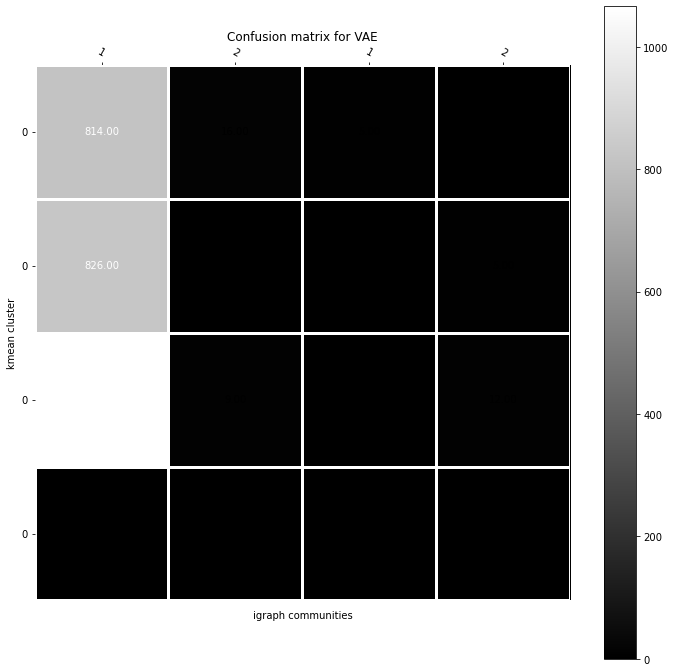

In [62]:
from sklearn.metrics import confusion_matrix
#import seaborn as sns

#s.set_context("paper")

labels = kmeans.labels_
community = list(sorted_community_labels.values())
kmeanclusters = list(sorted_kmeans_labels.values())

mat = confusion_matrix(community, kmeanclusters)
fig, ax = plt.subplots(figsize=(12,12))  

im, cbar = heatmap(mat.T, community, kmeanclusters, ax)
annotate_heatmap(im, mat.T)
plt.title('Confusion matrix for VAE')
plt.xlabel('igraph communities')
plt.ylabel('kmean cluster')

#im, cbar = heatmap(mat.T, community, kmeanclusters, square=False, annot=True, fmt='d', cbar=False, cmap="YlGnBu", ax=ax)

In [63]:
plt.savefig('CommMatrixVAE10epochs.png')

<Figure size 432x288 with 0 Axes>